In [238]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
# Read in the image
image = cv2.imread('imgs/recordings/record-000015.png')
open_cv_image = np.array(image)
resized_image = cv2.resize(open_cv_image, (64,64))
colors = np.array(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))/255.0
image = np.array(cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV))/255.0

width = image.shape[1]
height = image.shape[0]


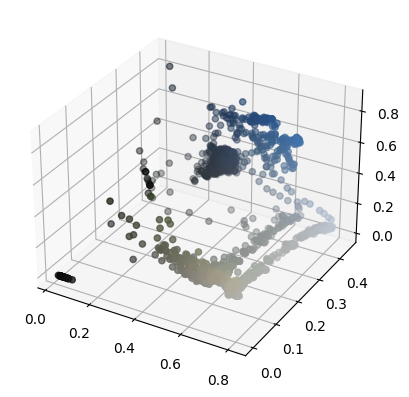

In [239]:
# 3d scatter plot
ax = plt.figure().add_subplot(projection='3d')
points = image.reshape((-1,3))
colors = colors.reshape((-1,3))
#points = np.apply_along_axis(lambda x: [x[0], x[1], x[2]], 1,points)

ax.scatter(points[:,2], points[:,0], points[:,1], c=colors, marker='o')


In [240]:
# mean shift clustering
from sklearn.cluster import MeanShift, estimate_bandwidth
#bandwidth = estimate_bandwidth(points, quantile=0.2, n_samples=500)
bandwidth = 0.16
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_



In [266]:
def run_meanshift(points):
    bandwidth = estimate_bandwidth(points, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(points)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    return labels, cluster_centers

def get_segmented_image(image, labels, cluster_centers):
    segmented_image = np.zeros_like(image)
    for i in range(len(labels)):
        segmented_image[i//width][i%width] = cluster_centers[labels[i]]
    return segmented_image






(64, 64, 5)


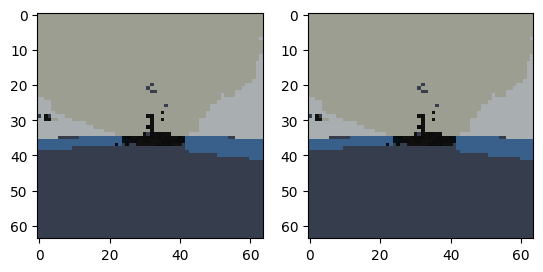

In [267]:
run_meanshift(image.reshape((-1,3)))
segmented_image = get_segmented_image(image, labels, cluster_centers)
segmented_image = cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)
plt.subplot(1,2,1)
plt.imshow(segmented_image)
plt.subplot(1,2,2)

# UV-Map
uv_map = np.zeros((height, width,2))
for i in range(height):
    for j in range(width):
        uv_map[i][j] = [i/height, j/width]

img_and_uv = np.concatenate((segmented_image, uv_map), axis=2)
print(img_and_uv.shape)
run_meanshift(img_and_uv.reshape((-1,5)))
segmented_image = get_segmented_image(image, labels, cluster_centers[:,0:3])
segmented_image = cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)
plt.imshow(segmented_image)






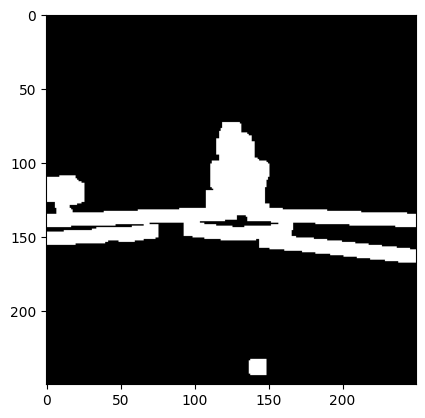

In [241]:
canny = cv2.Canny(open_cv_image, 100, 200)
canny = cv2.dilate(canny, None, iterations=4)
plt.imshow(canny, cmap='gray')

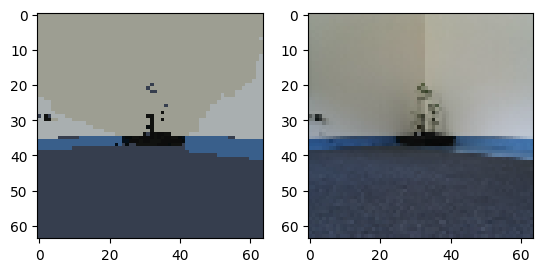

In [242]:
# labeled image 
image_label = labels.reshape((height, width))

resuliting_img = np.ones((height, width, 3))
#print(image_label.shape)
#print(np.unique(image_label))
for i in range(len(cluster_centers)):
    #print(i)
    
    #print(cluster_centers[i])
    mask = image_label == i
    #print('num',np.sum(mask))
    resuliting_img[mask] = cluster_centers[i]

resuliting_img = cv2.cvtColor((resuliting_img * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)


plt.subplot(1,2,1)
plt.imshow(resuliting_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(colors.reshape((height, width, 3)))

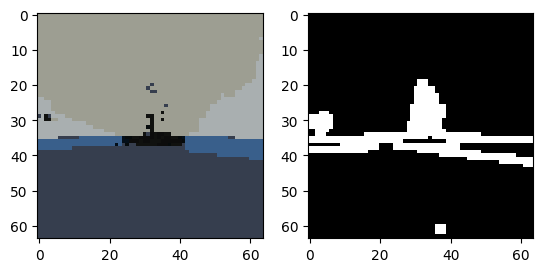

In [243]:
new_canny = cv2.cvtColor(canny, cv2.COLOR_GRAY2RGB)
new_canny = cv2.resize(new_canny, (64,64), interpolation=cv2.INTER_NEAREST)
new_canny = np.array(new_canny, dtype=np.uint8)/255.0



plt.subplot(1,2,1)
plt.imshow(resuliting_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(new_canny, cmap='gray')

4

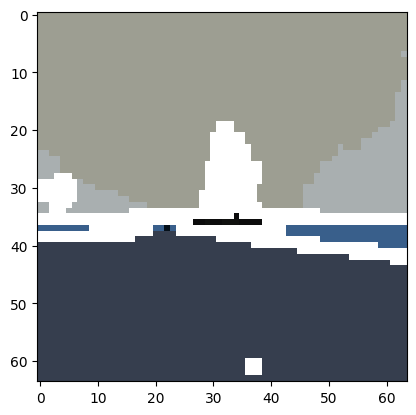

In [244]:
new_img = resuliting_img.copy() / 255.0 + new_canny

new_img[new_img > 1] = 1

plt.imshow(new_img, cmap='gray')
np.min(resuliting_img)
